In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd '/content/gdrive/My Drive/LDS0_K282_ONLINE_VienTriThienAnh/Project 3/'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS0_K282_ONLINE_VienTriThienAnh/Project 3


In [2]:
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the data
df = pd.read_csv("Files/Data_RFM.csv")

In [4]:
# subset the data to only include RFM columns
X = df[['Recency','Frequency','Monetary']]

In [5]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [7]:
# set the range of number of clusters to try
k_range = range(2, 11)

In [8]:
# initialize variables to store the best parameters and silhouette score
best_k = None
best_score = -1

In [9]:
# loop over all numbers of clusters to try
for k in k_range:
    
    # initialize the Mini-Batch K-Means model with the current number of clusters
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, max_iter=100)
    
    # fit the model to the data
    kmeans.fit(X_pca)
    
    # calculate the silhouette score
    score = silhouette_score(X_pca, kmeans.labels_)
    
    # update the best score and parameters if the current score is better
    if score > best_score:
        best_score = score
        best_k = k

In [10]:
# print the best number of clusters and silhouette score
print("Best number of clusters:", best_k)
print("Silhouette score:", best_score)

Best number of clusters: 3
Silhouette score: 0.7013556825718619


In [11]:
data_RFM = X.copy()

In [12]:
# initialize MiniBatchKMeans with the best k value
kmeans = MiniBatchKMeans(n_clusters=best_k, batch_size=100, random_state=42)

# fit and transform the data
cluster_labels = kmeans.fit_predict(X)

# add the cluster labels to the original data
data_rfm_clustered = data_RFM.assign(cluster=cluster_labels)

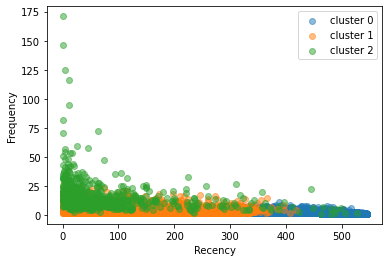

In [13]:
for cluster in set(data_rfm_clustered['cluster']):
    plt.scatter(data_rfm_clustered[data_rfm_clustered['cluster'] == cluster]['Recency'],
                data_rfm_clustered[data_rfm_clustered['cluster'] == cluster]['Frequency'],
                label='cluster {}'.format(cluster), alpha=0.5)
    
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
#Visualizing clusters 
fig = px.scatter_3d(data_rfm_clustered, x='Recency', y= 'Monetary', z='Frequency', color = 'cluster')
fig.show()

In [15]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = data_rfm_clustered.groupby('cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

# Change the Cluster Columns Datatype into discrete values
rfm_agg['cluster'] = 'cluster '+ rfm_agg['cluster'].astype('str')

# Print the aggregated dataset
rfm_agg

,cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,cluster 0,483.0,1.0,43.0,16001,67.89
1,cluster 1,127.0,5.0,161.0,6863,29.12
2,cluster 2,75.0,16.0,1005.0,706,3.00


- cluster 0: Low spend spend and long time since last purchase
- cluster 1: Moderate spend and moderate time since last purchase
- cluster 2: High spend and recent purchase.

### Conclude
- Mini-Batch Kmeans' silhouette score is 0.7 so it's better than Kmeans and Hierarchical clustering